In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle

In [2]:
full_data = pd.read_csv('weatherAUS.csv')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [3]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

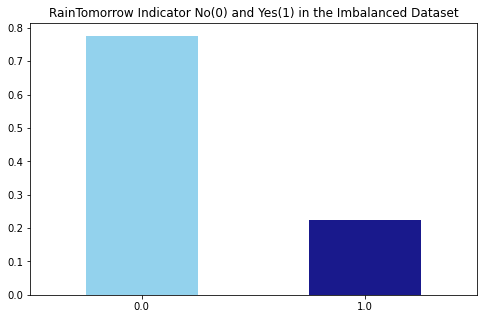

In [5]:
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In [6]:
full_data.head()
full_data.RainTomorrow

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
145455    0.0
145456    0.0
145457    0.0
145458    0.0
145459    NaN
Name: RainTomorrow, Length: 145460, dtype: float64

## Handling Class Imbalance For Rainfall Prediction

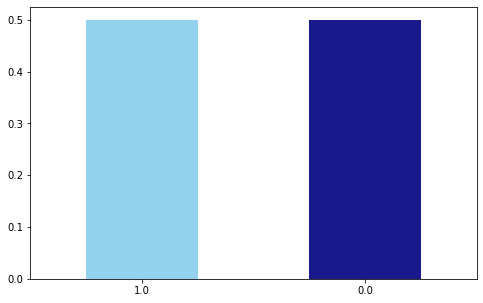

In [7]:
from sklearn.utils import resample
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)

## missing data model in the dataset

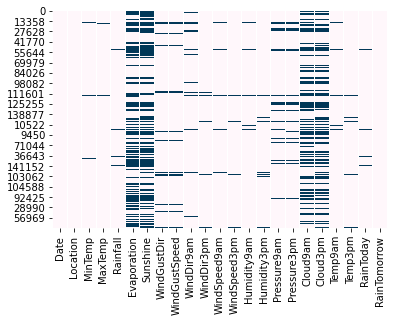

In [8]:

sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [9]:
#Obviously, “Evaporation”, “Sunshine”, “Cloud9am”, “Cloud3pm” are the features with a high missing percentage. 
#So we will check the details of the missing data for these 4 features.

In [10]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [11]:
#We observe that the 4 features have less than 50 per cent missing data. 
#So instead of rejecting them completely, we’ll consider them in our model with proper imputation.

## Imputation and Transformation

In [12]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [13]:
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [14]:
# Convert categorical features to continuous features with Label Encoding
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [15]:
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [16]:
#detect and eliminate outliers

In [17]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [18]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(170669, 23)

In [19]:
#We observe that the original dataset had the form (87927, 24). 
#After running a code snippet for removing outliers, the dataset now has the form (86065, 24). 
#As a result, the dataset is now free of 1862 outliers. We are now going to check multicollinearity, 
#that is to say if a character is strongly correlated with another.

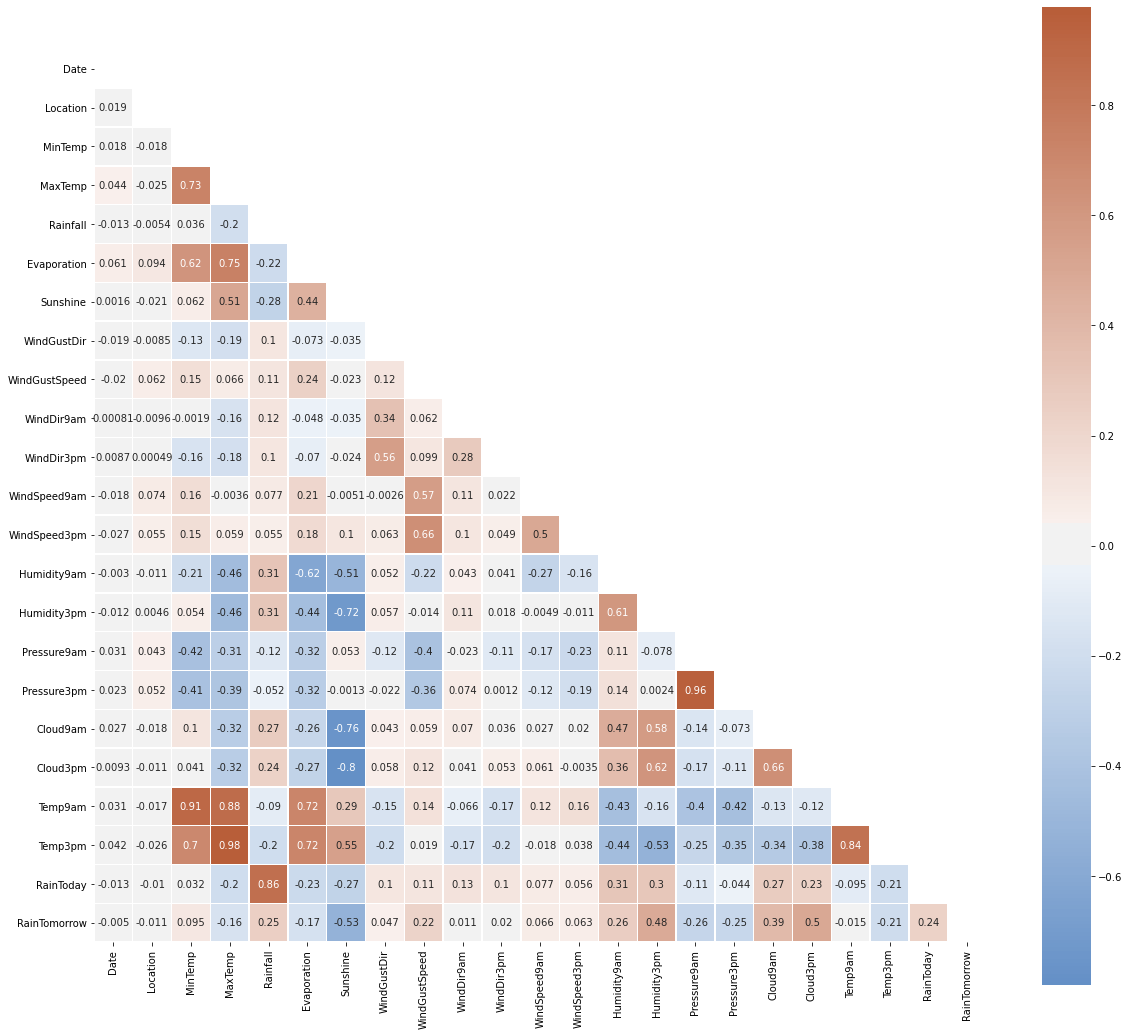

In [20]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

## Feature Selection for Rainfall Prediction

In [21]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [22]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [23]:
X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03253427 0.02881107 0.03314079 0.03249158 0.02143225 0.03311921
 0.13843799 0.02077917 0.04263648 0.021398   0.02169729 0.02179529
 0.02339751 0.0344056  0.10634039 0.0483552  0.06129439 0.05797767
 0.13958632 0.03162141 0.03627126 0.01247686]


## Training Rainfall Prediction Model with Different Models

In [24]:
#We will divide the dataset into training (75%) and test (25%) sets respectively to train the rainfall prediction model. 
#For best results, we will standardize our X_train and X_test data:

In [25]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [26]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [27]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7952798350051561
ROC Area under Curve = 0.7895421146723749
Cohen's Kappa = 0.5823246558119864
Time taken = 2.6179938316345215
              precision    recall  f1-score   support

         0.0    0.80459   0.83764   0.82078     23879
         1.0    0.78229   0.74144   0.76132     18789

    accuracy                        0.79528     42668
   macro avg    0.79344   0.78954   0.79105     42668
weighted avg    0.79477   0.79528   0.79460     42668



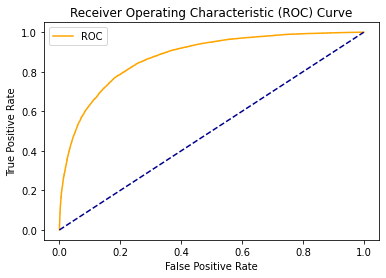

Accuracy = 0.8618636917596325
ROC Area under Curve = 0.8622973087092936
Cohen's Kappa = 0.7210932861568544
Time taken = 0.5545156002044678
              precision    recall  f1-score   support

         0.0    0.89059   0.85866   0.87433     23879
         1.0    0.82820   0.86593   0.84665     18789

    accuracy                        0.86186     42668
   macro avg    0.85939   0.86230   0.86049     42668
weighted avg    0.86312   0.86186   0.86214     42668



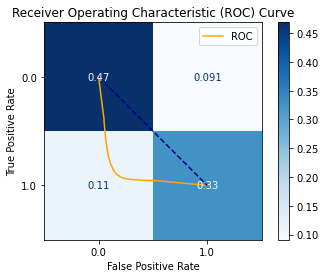

Accuracy = 0.9265960438736289
ROC Area under Curve = 0.9279584837896794
Cohen's Kappa = 0.8517906871231153
Time taken = 31.19561529159546
              precision    recall  f1-score   support

         0.0    0.95053   0.91654   0.93323     23879
         1.0    0.89854   0.93938   0.91851     18789

    accuracy                        0.92660     42668
   macro avg    0.92454   0.92796   0.92587     42668
weighted avg    0.92764   0.92660   0.92674     42668



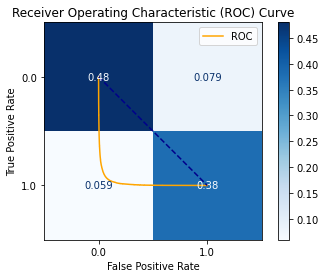

[18:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy = 0.9496109496578232
ROC Area under Curve = 0.9524401225294207
Cohen's Kappa = 0.8984891049787654
Time taken = 140.12374758720398
              precision    recall  f1-score   support

         0.0    0.98020   0.92872   0.95377     23879
         1.0    0.91508   0.97616   0.94463     18789

    accuracy                        0.94961     42668
   macro avg    0.94764   0.95244   0.94920     42668
weighted avg    0.95152   0.94961   0.94975     42668



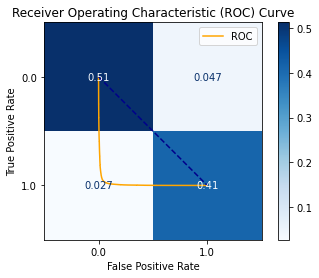

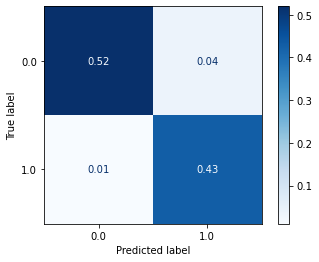

In [28]:
# Logistic Regression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}
model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# XGBoost

params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)


## Rainfall Prediction Model Comparison

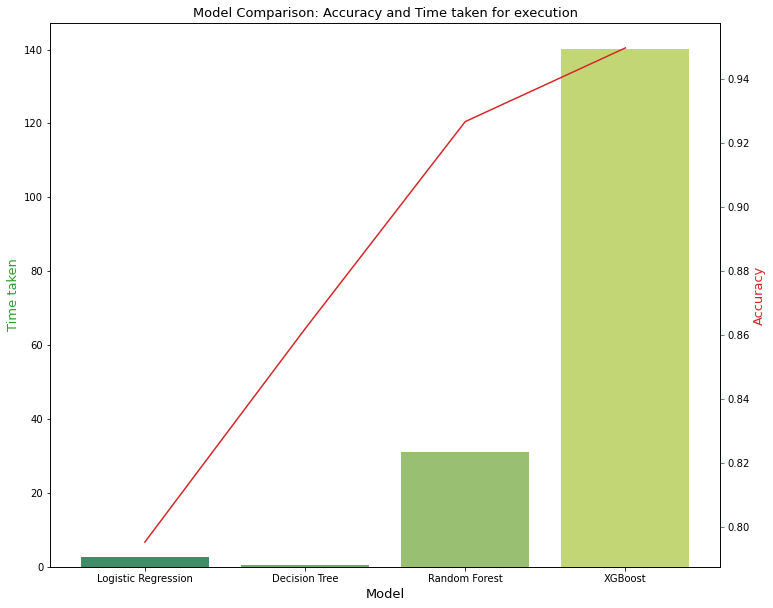

In [29]:
accuracy_scores = [accuracy_lr, accuracy_dt,  accuracy_rf, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt,  roc_auc_rf,  roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt,  coh_kap_rf,  coh_kap_xgb]
tt = [tt_lr, tt_dt,  tt_rf,  tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

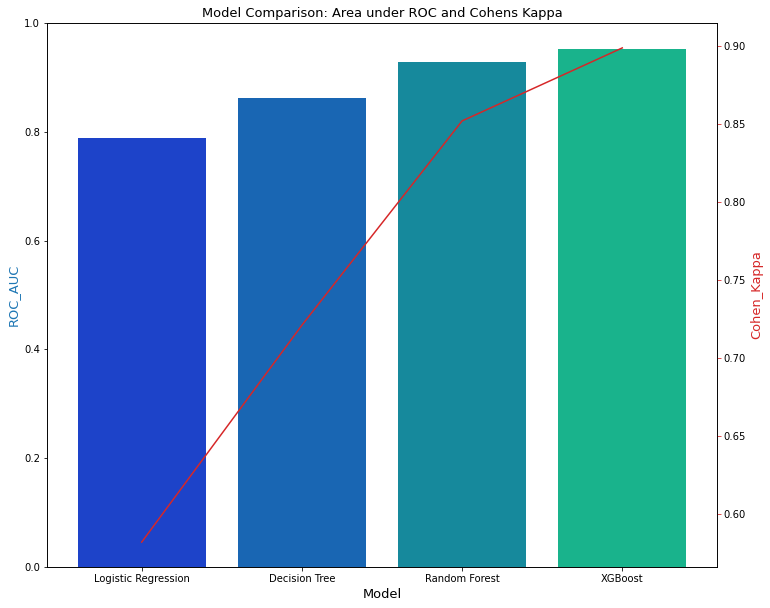

In [30]:
ig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

In [31]:
#We can observe that XGBoost, CatBoost and Random Forest performed better compared to other models. 
#However, if speed is an important thing to consider, we can stick with Random Forest instead of XGBoost or CatBoost.

In [32]:
# XGBoost

params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(params_xgb)

model_xgb.fit(X_train,y_train)

XGBoostError: [18:20:19] C:\Users\Administrator\workspace\xgboost-win64_release_1.3.0\src\objective\objective.cc:26: Unknown objective function: `{'n_estimators': 500, 'max_depth': 16}`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: reg:pseudohubererror
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear


In [ ]:
# Creating a pickle file for the model
filename = 'Rainfall_Prediction.pkl'
pickle.dump(model_xgb, open(filename, 'wb'))

In [ ]:
X_test
features
type(y_test)
type(X_test)

In [ ]:
#save the data columns
import json

columns = {'data_columns' : [col.lower() for col in features]}

with open("columns.json","w") as f:
    f.write(json.dumps(columns))    

In [ ]:
y1 = model_xgb.predict()

In [ ]:
full_data

In [ ]:
X_train[0]

In [ ]:
X_test